<a href="https://colab.research.google.com/github/grahyachowdary/sentiment_analysis/blob/main/Sentiment(project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji
import pandas as pd
import numpy as np
import emoji
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
# Enhanced text preprocessing
def convert_emojis(text):
    return emoji.demojize(str(text))

def preprocess_text(text):
    # Convert emojis to text
    text = convert_emojis(text)

    # Convert emoticons to words
    emoticon_dict = {
        ':)': 'happy',
        ':(': 'sad',
        ':D': 'very_happy',
        ':P': 'playful',
        ':O': 'surprised',
        ':/': 'skeptical'
    }
    for emoticon, word in emoticon_dict.items():
        text = text.replace(emoticon, word)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase
    text = text.lower().strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/file.csv')
df['processed_tweets'] = df['tweets'].apply(preprocess_text)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Class distribution before upsampling:
labels
bad        107796
good        56011
neutral     55487
Name: count, dtype: int64


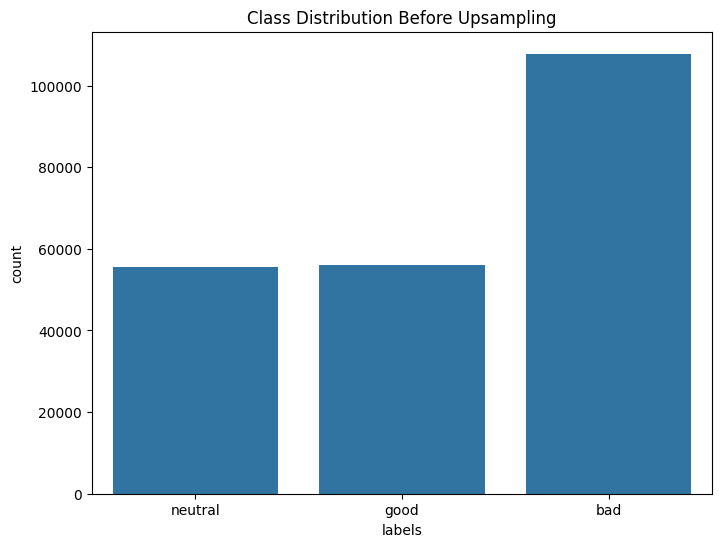

In [ ]:
print("Class distribution before upsampling:")
print(df['labels'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='labels')
plt.title('Class Distribution Before Upsampling')
plt.show()

In [ ]:
# Import the resample function
from sklearn.utils import resample

# Print unique labels and their counts before processing
print("Original unique labels:", df['labels'].unique())
print("\nOriginal label counts:")
print(df['labels'].value_counts())

# Make sure you're correctly identifying all three classes
df_bad = df[df['labels'] == 'bad']
df_good = df[df['labels'] == 'good']
df_neutral = df[df['labels'] == 'neutral']

# Upsample to match the majority class (bad)
df_good_upsampled = resample(df_good,
                           replace=True,
                           n_samples=len(df_bad),
                           random_state=42)
df_neutral_upsampled = resample(df_neutral,
                              replace=True,
                              n_samples=len(df_bad),
                              random_state=42)

# Combine all classes
df_balanced = pd.concat([df_bad, df_good_upsampled, df_neutral_upsampled])

# Check final distribution
print("\nFinal label counts:")
print(df_balanced['labels'].value_counts())

Original unique labels: ['neutral' 'good' 'bad']

Original label counts:
labels
bad        107796
good        56011
neutral     55487
Name: count, dtype: int64

Final label counts:
labels
bad        107796
good       107796
neutral    107796
Name: count, dtype: int64


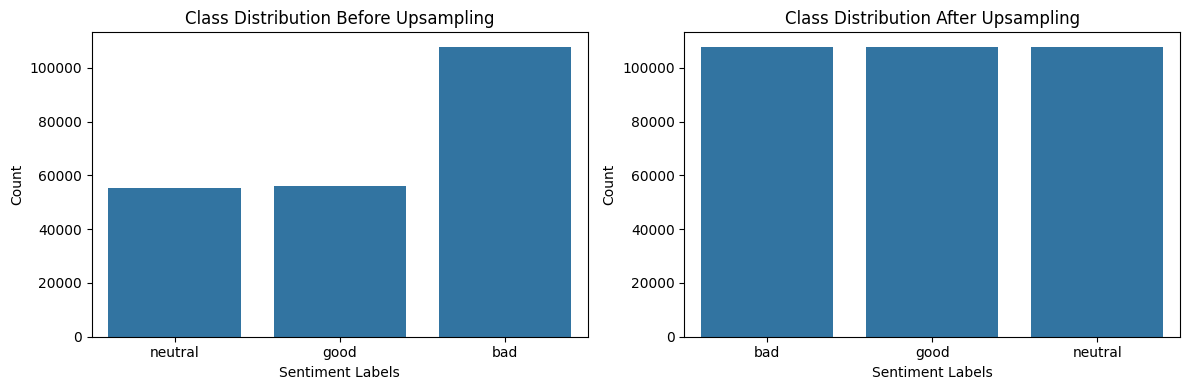

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution before upsampling
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='labels')
plt.title('Class Distribution Before Upsampling')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')

# Plot distribution after upsampling
plt.subplot(1, 2, 2)
sns.countplot(data=df_balanced, x='labels')
plt.title('Class Distribution After Upsampling')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

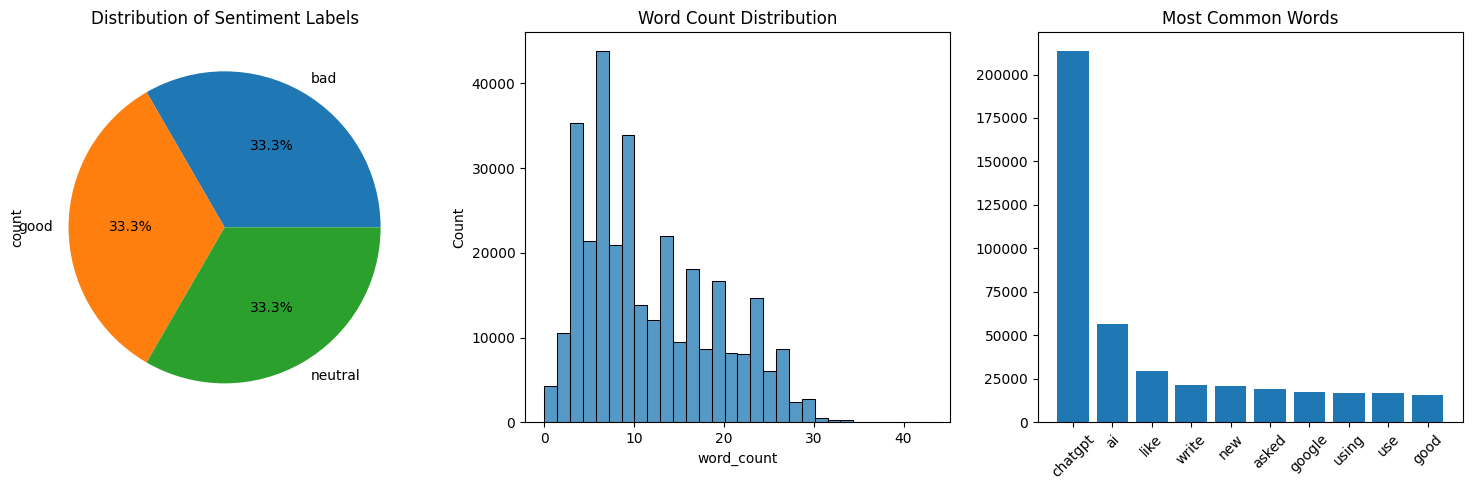

In [ ]:
df = df_balanced
def plot_data_analysis(df):
    plt.figure(figsize=(15, 5))

    # Distribution of sentiment labels
    plt.subplot(131)
    df['labels'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribution of Sentiment Labels')

    # Word count distribution
    plt.subplot(132)
    df['word_count'] = df['processed_tweets'].apply(lambda x: len(str(x).split()))
    sns.histplot(data=df, x='word_count', bins=30)
    plt.title('Word Count Distribution')

    # Most common words
    plt.subplot(133)
    all_words = ' '.join(df['processed_tweets']).split()
    word_freq = Counter(all_words).most_common(10)
    words, freq = zip(*word_freq)
    plt.bar(words, freq)
    plt.xticks(rotation=45)
    plt.title('Most Common Words')

    plt.tight_layout()
    plt.show()

plot_data_analysis(df)

In [ ]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split


# Data Generator for memory efficiency
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=64):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y



# Convert labels to numerical values
label_map = {'good': 2, 'neutral': 1, 'bad': 0}
df['labels_num'] = df['labels'].map(label_map)

# Tokenization and padding
print("Tokenizing and padding sequences...")
max_words = 10000  # Increased for larger dataset
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_tweets'])
sequences = tokenizer.texts_to_sequences(df['processed_tweets'])
X = pad_sequences(sequences, maxlen=max_len)
y = df['labels_num']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create generators
train_generator = DataGenerator(X_train, y_train)
test_generator = DataGenerator(X_test, y_test)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


Tokenizing and padding sequences...


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

def create_and_train_cnn():
    # Define the model
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        Conv1D(256, 5, activation='relu'),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    # Compile with optimized learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=4,             # Long patience allows more epochs
        min_delta=0.0001,        # Even small improvements count
        restore_best_weights=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=300,
        validation_data=test_generator,
        callbacks=[reduce_lr, early_stopping],
        batch_size=128,
        verbose=1
    )

    return model, history

# Train the model
cnn_model, cnn_history = create_and_train_cnn()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4043/4043 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - accuracy: 0.7072 - loss: 0.6988 - val_accuracy: 0.8817 - val_loss: 0.3367 - learning_rate: 0.0010
Epoch 2/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9003 - loss: 0.2996 - val_accuracy: 0.9084 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 3/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9309 - loss: 0.2108 - val_accuracy: 0.9212 - val_loss: 0.2533 - learning_rate: 0.0010
Epoch 4/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9521 - loss: 0.1498 - val_accuracy: 0.9293 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 5/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9645 - loss: 0.1120 - val_accuracy: 0.9328 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 6/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9724 - loss: 0.0885 - val_accuracy: 0.9312 - val_loss: 0.2484 - learning_rate: 0.0010
Epoch 7/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9783 -

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Display model summary
cnn_model.summary()

# Predict on test data
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]  # Extract batch labels
    y_true.extend(np.argmax(labels, axis=-1) if labels.ndim > 1 else labels)  # Ensure correct label format

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 94, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 94, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,579 (18.42 MB)

 Trainable params: 1,609,603 (6.14 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 3,219,208 (12.28 MB)

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Accuracy: 0.9468
Precision: 0.9471
Recall: 0.9468
F1 Score: 0.9469

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     21574
           1       0.92      0.94      0.93     21532
           2       0.97      0.96      0.96     21572

    accuracy                           0.95     64678
   macro avg       0.95      0.95      0.95     64678
weighted avg       0.95      0.95      0.95     64678



dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


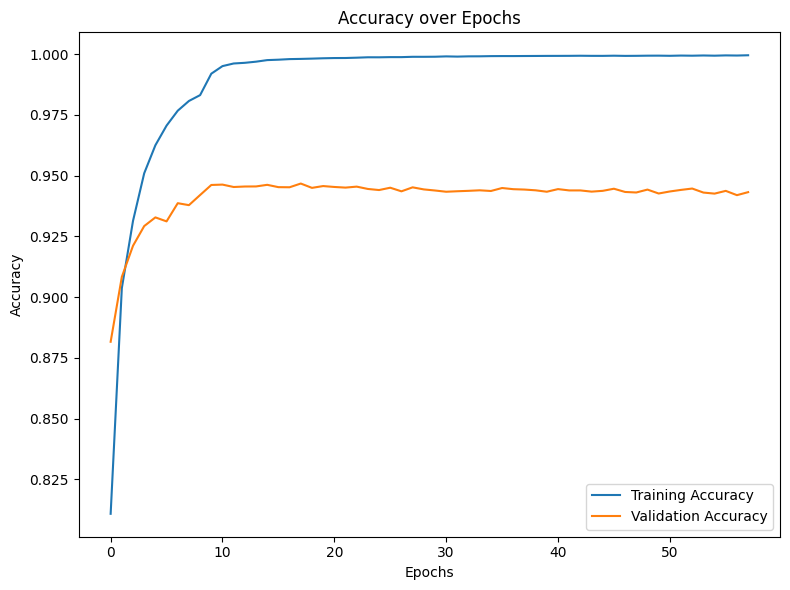

In [ ]:
import matplotlib.pyplot as plt

# Assuming cnn_history is available from the training process
history = cnn_history.history  # This contains the history of the training process

# Print available keys to check the correct metric names
print(history.keys())  # Check the keys in the history to confirm 'accuracy' is present

# Plot training accuracy
plt.figure(figsize=(8, 6))

# Plot training accuracy
plt.plot(history['accuracy'], label='Training Accuracy')

# Plot validation accuracy (if available)
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


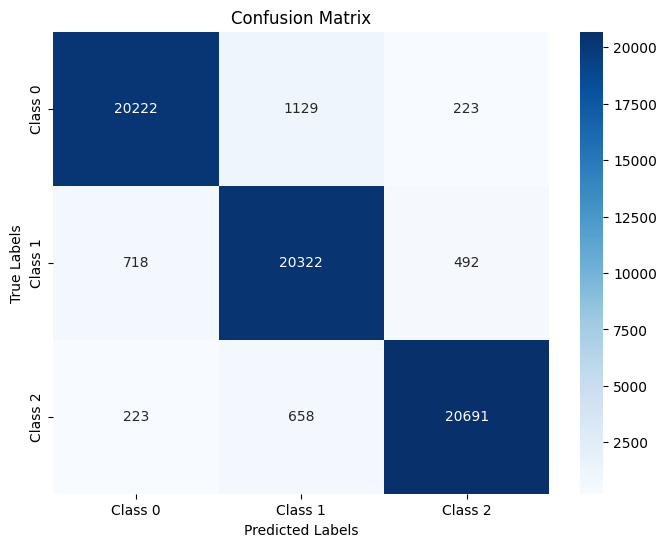

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]  # Extract batch labels
    y_true.extend(np.argmax(labels, axis=-1) if labels.ndim > 1 else labels)  # Ensure correct label format

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

def create_and_train_lstm():
    # Define the model
    model = Sequential([
        Embedding(max_words, 64, input_length=max_len),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        LSTM(32),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',  # Optionally switch to 'val_loss' if needed
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',   # Switch to 'val_loss' for faster stopping
        patience=4,              # Allows more training before stopping
        min_delta=0.001,          # Accepts small improvements
        restore_best_weights=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=300,
        validation_data=test_generator,
        callbacks=[reduce_lr, early_stopping],
        batch_size=64,
        verbose=1
    )

    return model, history

# Train the model
lstm_model, lstm_history = create_and_train_lstm()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4043/4043 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - accuracy: 0.7774 - loss: 0.5444 - val_accuracy: 0.9017 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 2/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 67s 17ms/step - accuracy: 0.9131 - loss: 0.2658 - val_accuracy: 0.9156 - val_loss: 0.2578 - learning_rate: 0.0010
Epoch 3/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - accuracy: 0.9356 - loss: 0.1996 - val_accuracy: 0.9253 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 4/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - accuracy: 0.9505 - loss: 0.1547 - val_accuracy: 0.9335 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 5/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.9622 - loss: 0.1212 - val_accuracy: 0.9369 - val_loss: 0.2193 - learning_rate: 0.0010
Epoch 6/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - accuracy: 0.9705 - loss: 0.0945 - val_accuracy: 0.9401 - val_loss: 0.2212 - learning_rate: 0.0010
Epoch 7/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Display model summary
lstm_model.summary()

# Predict on test data
y_pred_probs = lstm_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]  # Extract batch labels
    y_true.extend(np.argmax(labels, axis=-1) if labels.ndim > 1 else labels)  # Ensure correct label format

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,069,963 (7.90 MB)

 Trainable params: 689,923 (2.63 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 1,379,848 (5.26 MB)

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Accuracy: 0.9502
Precision: 0.9505
Recall: 0.9502
F1 Score: 0.9502

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95     21574
           1       0.93      0.95      0.94     21532
           2       0.96      0.97      0.97     21572

    accuracy                           0.95     64678
   macro avg       0.95      0.95      0.95     64678
weighted avg       0.95      0.95      0.95     64678



dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


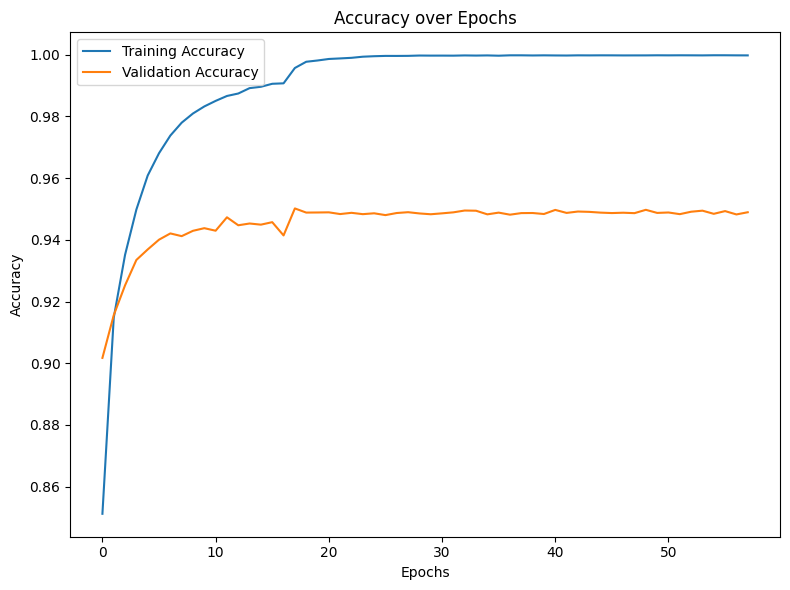

In [ ]:
import matplotlib.pyplot as plt

# Assuming lstm_history contains the training history object
history = lstm_history.history  # This contains the training history of the LSTM model

# Print available keys to check the correct metric names
print(history.keys())  # Check if 'accuracy' and 'val_accuracy' exist in the history

# Plot training accuracy
plt.figure(figsize=(8, 6))

# Plot training accuracy
plt.plot(history['accuracy'], label='Training Accuracy')

# Plot validation accuracy (if available)
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


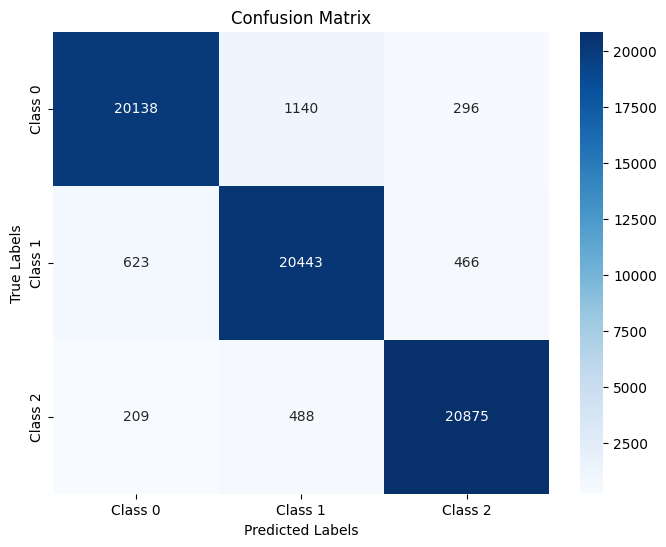

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred_probs = lstm_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]  # Extract batch labels
    y_true.extend(np.argmax(labels, axis=-1) if labels.ndim > 1 else labels)  # Ensure correct label format

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, MaxPooling1D # Import MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

def create_and_train_cnn_lstm():
    model = Sequential([
        Embedding(max_words, 100, input_length=max_len),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(2),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',    # or 'val_loss' if you prefer
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=4,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=300,
        validation_data=test_generator,
        callbacks=[reduce_lr, early_stopping],
        batch_size=64,
        verbose=1
    )

    return model, history

# Train the model
cnn_lstm_model, cnn_lstm_history = create_and_train_cnn_lstm()


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4043/4043 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - accuracy: 0.7886 - loss: 0.5335 - val_accuracy: 0.8928 - val_loss: 0.3158 - learning_rate: 0.0010
Epoch 2/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 54s 13ms/step - accuracy: 0.9220 - loss: 0.2506 - val_accuracy: 0.9218 - val_loss: 0.2495 - learning_rate: 0.0010
Epoch 3/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 54s 13ms/step - accuracy: 0.9481 - loss: 0.1710 - val_accuracy: 0.9338 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 4/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.9662 - loss: 0.1160 - val_accuracy: 0.9432 - val_loss: 0.2071 - learning_rate: 0.0010
Epoch 5/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.9760 - loss: 0.0830 - val_accuracy: 0.9419 - val_loss: 0.2135 - learning_rate: 0.0010
Epoch 6/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - accuracy: 0.9809 - loss: 0.0646 - val_accuracy: 0.9464 - val_loss: 0.2246 - learning_rate: 0.0010
Epoch 7/300
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Display model summary
cnn_lstm_model.summary()

# Predict on test data
y_pred_probs = cnn_lstm_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]  # Extract batch labels
    y_true.extend(np.argmax(labels, axis=-1) if labels.ndim > 1 else labels)  # Ensure correct label format

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 48, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,785,675 (14.44 MB)

 Trainable params: 1,261,891 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,523,784 (9.63 MB)

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
Accuracy: 0.9525
Precision: 0.9529
Recall: 0.9525
F1 Score: 0.9525

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     21574
           1       0.92      0.95      0.94     21532
           2       0.97      0.97      0.97     21572

    accuracy                           0.95     64678
   macro avg       0.95      0.95      0.95     64678
weighted avg       0.95      0.95      0.95     64678



dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


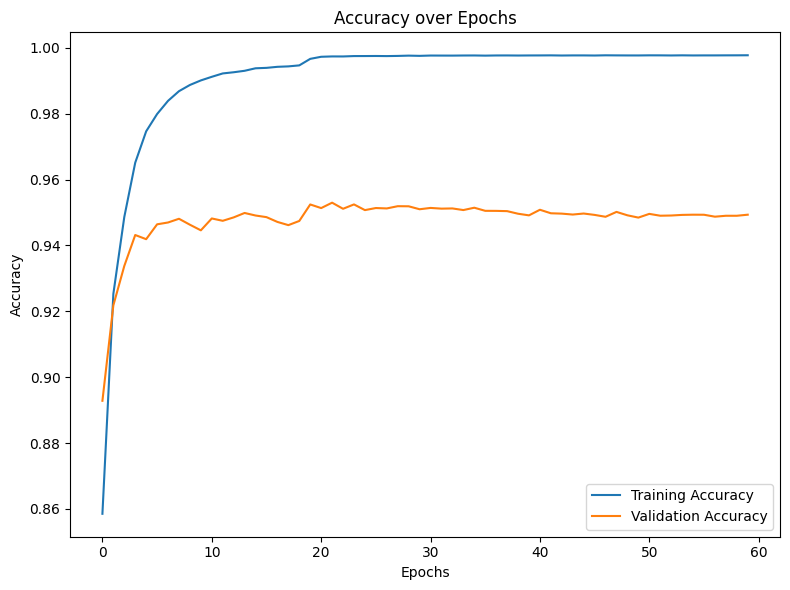

In [ ]:
import matplotlib.pyplot as plt

# Assuming cnn_lstm_history contains the training history object
history = cnn_lstm_history.history  # This contains the training history

# Print available keys to check the correct metric names
print(history.keys())  # Check the keys to ensure 'accuracy' and 'val_accuracy' exist

# Plot training accuracy
plt.figure(figsize=(8, 6))

# Plot training accuracy
plt.plot(history['accuracy'], label='Training Accuracy')

# Plot validation accuracy (if available)
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


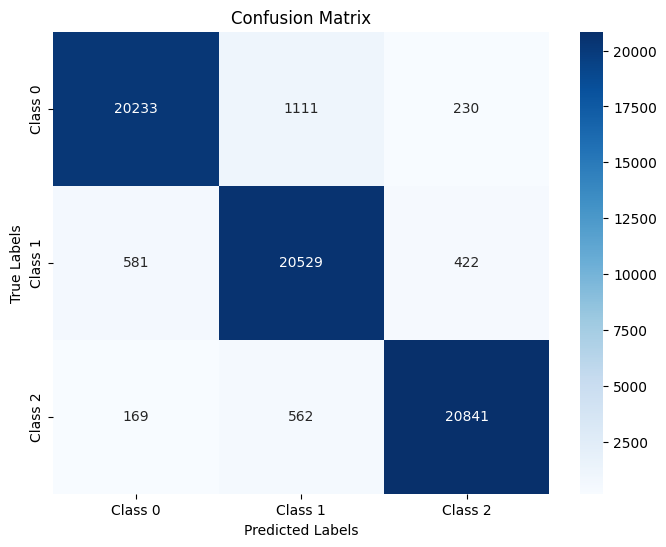

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred_probs = cnn_lstm_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]  # Extract batch labels
    y_true.extend(np.argmax(labels, axis=-1) if labels.ndim > 1 else labels)  # Ensure correct label format

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Ensure vader_lexicon is downloaded
nltk.download('vader_lexicon')

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to predict sentiment using VADER
def predict_sentiment_vader(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'good'
    elif scores['compound'] <= -0.05:
        return 'bad'
    else:
        return 'neutral'

# Sample DataFrame (Ensure df is pre-loaded with processed tweets and labels)
# df = pd.read_csv("your_dataset.csv")  # Uncomment if loading from a CSV
# df['processed_tweets'] should contain preprocessed text data
# df['labels_num'] should contain true sentiment labels (0: bad, 1: neutral, 2: good)

# Apply VADER sentiment analysis to the preprocessed tweets
df['vader_sentiment'] = df['processed_tweets'].apply(predict_sentiment_vader)

# Convert VADER sentiment predictions to numerical labels
label_map_vader = {'good': 2, 'neutral': 1, 'bad': 0}
df['vader_sentiment_num'] = df['vader_sentiment'].map(label_map_vader)

# Calculate metrics for VADER
y_true = df['labels_num']  # Use the original numerical labels
y_pred_vader = df['vader_sentiment_num']

accuracy_vader = accuracy_score(y_true, y_pred_vader)
precision_vader = precision_score(y_true, y_pred_vader, average='weighted', zero_division=0)
recall_vader = recall_score(y_true, y_pred_vader, average='weighted', zero_division=0)
f1_vader = f1_score(y_true, y_pred_vader, average='weighted', zero_division=0)

print("VADER Sentiment Analysis Metrics:")
print(f"Accuracy: {accuracy_vader}")
print(f"Precision: {precision_vader}")
print(f"Recall: {recall_vader}")
print(f"F1 Score: {f1_vader}")

# Classification Report for VADER
print(classification_report(y_true, y_pred_vader, target_names=['bad', 'neutral', 'good']))





[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


VADER Sentiment Analysis Metrics:
Accuracy: 0.4520483134810197
Precision: 0.4762821054881811
Recall: 0.4520483134810197
F1 Score: 0.40439556615851674
              precision    recall  f1-score   support

         bad       0.83      0.33      0.47    107796
     neutral       0.09      0.07      0.08    107796
        good       0.51      0.96      0.67    107796

    accuracy                           0.45    323388
   macro avg       0.48      0.45      0.40    323388
weighted avg       0.48      0.45      0.40    323388



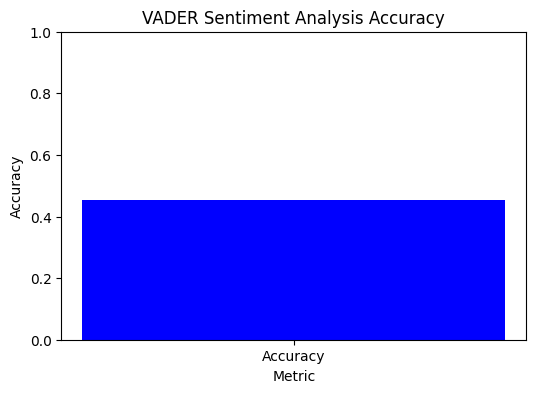

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.bar('Accuracy', accuracy_vader, color='blue')
plt.title('VADER Sentiment Analysis Accuracy')
plt.xlabel('Metric')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Since accuracy is between 0 and 1
plt.show()


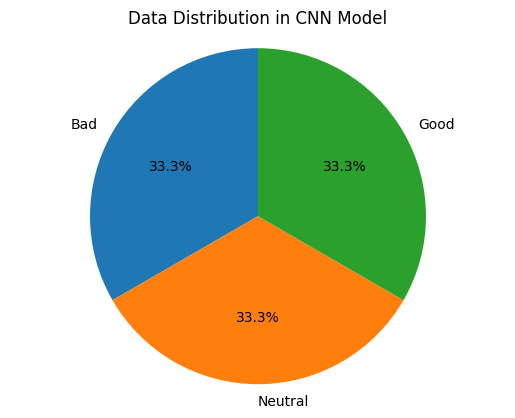

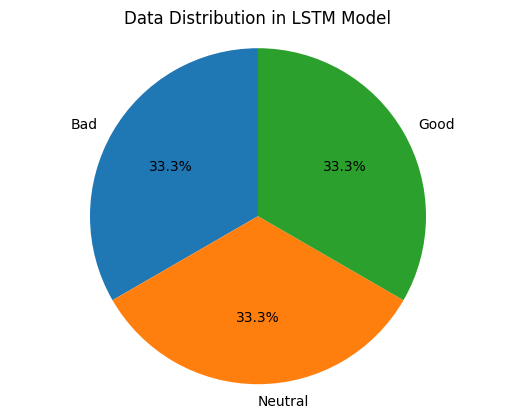

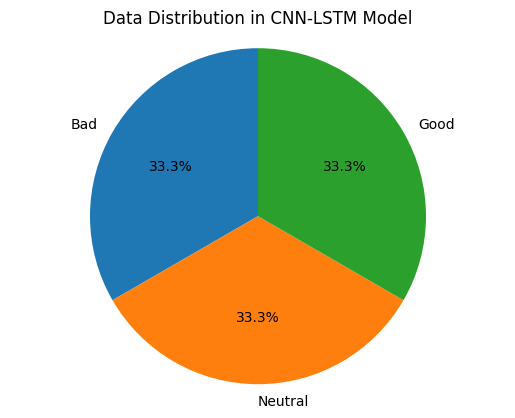

In [ ]:
# prompt: plot how much percentage of good, bad and neutral data in all models in pie charts

import matplotlib.pyplot as plt

def plot_model_data_distribution(y_true, model_name):
  """Plots the percentage distribution of good, bad, and neutral data for a given model.

  Args:
    y_true: A list or array of true labels (0: bad, 1: neutral, 2: good).
    model_name: The name of the model to display in the title.
  """

  label_counts = [sum(1 for label in y_true if label == 0),
                  sum(1 for label in y_true if label == 1),
                  sum(1 for label in y_true if label == 2)]

  labels = ['Bad', 'Neutral', 'Good']
  sizes = label_counts

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(f'Data Distribution in {model_name}')
  plt.show()

# Assuming you have the true labels for each model's test data
# For CNN
y_true_cnn = y_true  # Assuming 'y_true' is defined from the CNN evaluation
plot_model_data_distribution(y_true_cnn, "CNN Model")

# For LSTM
y_true_lstm = y_true  # Assuming 'y_true' is defined from the LSTM evaluation
plot_model_data_distribution(y_true_lstm, "LSTM Model")

# For CNN-LSTM
y_true_cnn_lstm = y_true  # Assuming 'y_true' is defined from the CNN-LSTM evaluation
plot_model_data_distribution(y_true_cnn_lstm, "CNN-LSTM Model")


# For VADER (if applicable)
# You'll need the true labels and VADER predictions:
# y_true_vader = ...
# y_pred_vader = ...
# Assuming you have y_true_vader for VADER, you can plot the distribution.
# plot_model_data_distribution(y_true_vader, "VADER")
